# general predictor

Input:

pretrained generate predictors for aesthetic, nsfw, etc

Output

generate predictors using clip-embedding as input

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
import json

import numpy as np
import pandas as pd

import requests

import msgpack
import zipfile

import torch

from PIL import Image
from io import BytesIO
from matplotlib import pyplot

from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModel, CLIPImageProcessor, pipeline, AutoModelForImageClassification

In [2]:
from utils import get_score_from_embs

In [3]:
BATCH_SIZE = 256

# aesthetic-predictor

In [ ]:
# https://github.com/LAION-AI/aesthetic-predictor

In [58]:
model = torch.nn.Linear(768, 1)

In [59]:
model.load_state_dict(torch.load('./weight/014/sa_0_4_vit_l_14_linear.pth'))

<All keys matched successfully>

In [60]:
model = model.cuda()
model.eval();

# improved-aesthetic-predictor

In [7]:
# https://github.com/christophschuhmann/improved-aesthetic-predictor

## convert to single layer

In [11]:
model = torch.nn.Sequential()
model.add_module('layers', torch.nn.Sequential(
    torch.nn.Linear(768, 1024),
    #nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 128),
    #nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 64),
    #nn.ReLU(),
    torch.nn.Dropout(0.1),

    torch.nn.Linear(64, 16),
    #nn.ReLU(),

    torch.nn.Linear(16, 1)
))

In [12]:
model.load_state_dict(torch.load('./weight/014/sac+logos+ava1-l14-linearMSE.pth'))

<All keys matched successfully>

In [59]:
weight = model.layers[0].weight
bias = model.layers[0].bias

for layer in [model.layers[2], model.layers[4], model.layers[6], model.layers[7]]:
    
    weight = layer.weight @ weight
    bias = layer.weight @ bias + layer.bias
    
model = torch.nn.Linear(768, 1)
model.weight.data = weight
model.bias.data = bias

In [61]:
torch.save(model.state_dict(), './weight/014/sac+logos+ava1-l14-linearMSE-single.pth')

## build

In [62]:
model = torch.nn.Linear(768, 1)

In [63]:
model.load_state_dict(torch.load('./weight/014/sac+logos+ava1-l14-linearMSE-single.pth'))

<All keys matched successfully>

In [13]:
model = model.cuda()
model.eval();

In [14]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

# NSFW-Detector

In [ ]:
# https://github.com/LAION-AI/CLIP-based-NSFW-Detector

## convert keras to pytorch

In [ ]:
# from tensorflow.keras.models import load_model
# model_dir = './weight/014/clip_autokeras_binary_nsfw/'
# model = load_model(model_dir, custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
# state_dict = dict()
# state_dict['norm.mean'] = model.layers[2].weights[0].numpy()
# state_dict['norm.variance'] = model.layers[2].weights[1].numpy()
# state_dict['linear_1.weight'] = model.layers[3].weights[0].numpy().T
# state_dict['linear_1.bias'] = model.layers[3].weights[1].numpy()
# state_dict['linear_2.weight'] = model.layers[5].weights[0].numpy().T
# state_dict['linear_2.bias'] = model.layers[5].weights[1].numpy()
# state_dict['linear_3.weight'] = model.layers[7].weights[0].numpy().T
# state_dict['linear_3.bias'] = model.layers[7].weights[1].numpy()
# state_dict['linear_4.weight'] = model.layers[9].weights[0].numpy().T
# state_dict['linear_4.bias'] = model.layers[9].weights[1].numpy()

# np.savez('./weight/014/lip_autokeras_binary_nsfw.npz', **state_dict)

## build 

In [13]:
class Normalization(torch.nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.register_buffer('mean', torch.zeros(shape))
        self.register_buffer('variance', torch.ones(shape))

    def forward(self, x):
        return (x - self.mean) / self.variance.sqrt()

class NSFWModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = Normalization([768])
        self.linear_1 = torch.nn.Linear(768, 64)
        self.linear_2 = torch.nn.Linear(64, 512)
        self.linear_3 = torch.nn.Linear(512, 256)
        self.linear_4 = torch.nn.Linear(256, 1)
        self.act = torch.nn.ReLU()

    def forward(self, x):
        x = self.norm(x)
        x = self.act(self.linear_1(x))
        x = self.act(self.linear_2(x))
        x = self.act(self.linear_3(x))
        x = self.linear_4(x)
        return x

In [14]:
model = NSFWModel().cuda()
npz = np.load('./weight/014/clip_autokeras_binary_nsfw.npz')
model.load_state_dict({k: torch.tensor(v) for k, v in npz.items()})

<All keys matched successfully>

## test on civitai

In [7]:
npz = np.load('../dataset/scrap/civitai-2023-11-14.npz', allow_pickle=True)

id_to_index = {j:i for i, j in enumerate(npz['id'])}

In [8]:
INPUT_DIR = '../dataset/civitai-stable-diffusion-337k'

In [9]:
ids = list()
vectors = list()
for fname in tqdm(os.listdir(os.path.join(INPUT_DIR, '/clip/')), leave=False):
    
    fid = int(os.path.splitext(fname)[0])
    if fid not in id_to_index:
        continue
    
    vectors.append(np.load(os.path.join(INPUT_DIR, '/clip/', fname)))
    
    ids.append(fid)

vectors = np.concatenate(vectors, axis=0)
indices = list(map(id_to_index.get, ids))

  0%|          | 0/80418 [00:00<?, ?it/s]

In [ ]:
nsfw = npz['nsfw'][indices]

In [61]:
scores = get_score_from_embs(vectors, model, BATCH_SIZE)#, preprocess=lambda x: x / x.norm(dim=-1, keepdim=True))

  0%|          | 0/309 [00:00<?, ?it/s]

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [62]:
roc_auc_score(nsfw, scores)

0.9443499579621821

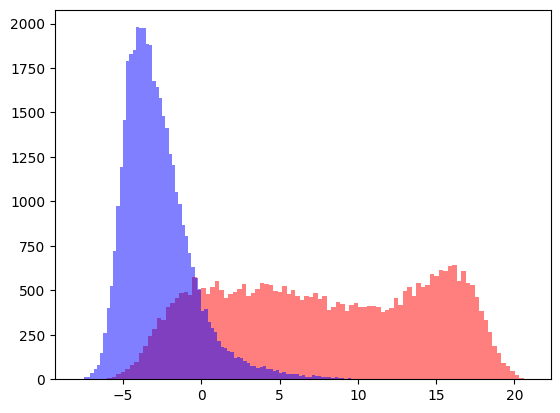

In [64]:
_ = pyplot.hist(scores[nsfw], bins=100, color='red', alpha=0.5)
_ = pyplot.hist(scores[~nsfw], bins=100, color='blue', alpha=0.5)

# nsfw_image_detection

In [ ]:
# model = AutoModel.from_pretrained("Falconsai/nsfw_image_detection", local_files_only=True).cuda().eval()

classifier = pipeline("image-classification", model="Falconsai/nsfw_image_detection", device=0, batch_size=BATCH_SIZE)
# img = Image.open("<path_to_image_file>")
# classifier(img)


## pre-compute scores

In [5]:
PMT_PATH = './data/environmental/prompt.json'

js = json.load(open(PMT_PATH))

In [9]:
file_names = [info['file_path'] for info in js.values()]
file_names = [os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i.replace('_data.msgpack', '.jpg')) for i in file_names]

In [10]:
results = list()

for i in tqdm(range(0, len(file_names), BATCH_SIZE)):
    
    with torch.no_grad():

        images = list()
        for file_name in file_names[i:i+BATCH_SIZE]:
            image = Image.open(file_name)
            images.append(image)
        
        results.extend(classifier(images))

  0%|          | 0/297 [00:00<?, ?it/s]

/home/xhxie/snap/kk-digital/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [12]:
file_paths = [file_name.replace('../kcg-ml-image-pipeline/output/dataset/image/', '').replace('.jpg', '') for file_name in file_names]

In [14]:
scores = [[j['score'] for j in i if j['label'] == 'nsfw'][0] for i in results]

In [16]:
np.savez(
    './data/environmental-nsfw-score.npz',
    file_names=np.array(file_names),
    scores=np.array(scores),
)

In [37]:
ZIP_PATH = './generated/generated-1116.zip'

In [38]:
f = zipfile.ZipFile(ZIP_PATH)

In [39]:
file_names = list()

files = set(f.namelist())

for file_path in f.namelist():
    
    if file_path.startswith('generated/image/') and file_path.endswith('.jpg'):
        
        file_names.append(file_path)

In [40]:
results = list()

for i in tqdm(range(0, len(file_names), BATCH_SIZE)):
    
    with torch.no_grad():

        images = list()
        for file_name in file_names[i:i+BATCH_SIZE]:
            image = Image.open(f.open(file_name))
            images.append(image)
        
        results.extend(classifier(images))

  0%|          | 0/73 [00:00<?, ?it/s]

/home/xhxie/snap/kk-digital/kcg-ml-image-pipeline/venv/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [42]:
file_paths = [file_name.replace('generated/image/', '').replace('.jpg', '') for file_name in file_names]

In [43]:
scores = [[j['score'] for j in i if j['label'] == 'nsfw'][0] for i in results]

In [44]:
np.savez(
    './data/generated-1116-nsfw-score.npz',
    file_names=np.array(file_names),
    scores=np.array(scores),
)

## load pre-computed scores & embeddings

In [10]:
score_list = list()
# image_emb_list = list()
text_emb_list = list()

In [11]:
for name in ['generated-1116', 'generated-1117', 'generated-1118']:

    npz = np.load(f'./data/{name}-nsfw-score.npz', allow_pickle=True)
    f = zipfile.ZipFile(f'./generated/{name}.zip')

    file_names = npz['file_names']
    scores = npz['scores']

    image_embs = list()
    text_embs = list()

    for file_name in tqdm(file_names, leave=False):

#         clip_path = file_name.replace('.jpg', '.npy').replace('/image/', '/clip/')
#         image_embs.append(np.load(f.open(clip_path)))

        clip_path = file_name.replace('.jpg', '.npz').replace('/image/', '/embedding/')
        npz = np.load(f.open(clip_path))
        text_embs.append(np.concatenate([npz['positive_pooler_output'], npz['negative_pooler_output']], axis=-1))

    # image_embs = np.concatenate(image_embs, axis=0)
    text_embs = np.concatenate(text_embs, axis=0)

    score_list.append(scores)
    # image_emb_list.append(image_embs)
    text_emb_list.append(text_embs)    


  0%|          | 0/18543 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/22186 [00:00<?, ?it/s]

In [68]:
npz = np.load(f'./data/civitai-nsfw-score.npz', allow_pickle=True)

file_names = npz['file_names']
scores = npz['scores']

image_embs = list()

for file_name in tqdm(file_names, leave=False):

    clip_path = os.path.join('../dataset/civitai-stable-diffusion-337k/clip/', f'{file_name}.npy')

    image_embs.append(np.load(clip_path))

image_embs = np.concatenate(image_embs, axis=0)

score_list.append(scores)
image_emb_list.append(image_embs)

  0%|          | 0/27903 [00:00<?, ?it/s]

In [21]:
npz = np.load(f'./data/environmental-nsfw-score.npz', allow_pickle=True)

file_names = npz['file_names']
scores = npz['scores']

path_to_index = {file_path.replace('../kcg-ml-image-pipeline/output/dataset/image/', '').replace('.jpg', ''): i for i, file_path in enumerate(file_names)}

# score_list.append(scores)

# image_embs = list()

# for file_name in tqdm(file_names, leave=False):

#     clip_path = file_name.replace('/image/', '/clip/').replace('.jpg', '_clip.msgpack')
    
#     image_embs.append(np.array(msgpack.load(open(clip_path, 'rb'))['clip-feature-vector']))

# image_embs = np.concatenate(image_embs, axis=0)

# image_emb_list.append(image_embs)

In [29]:
npz = np.load('./data/environmental/clip_text_emb.npz')

indices = [path_to_index[file_name[:25]] for file_name in npz['file_paths']]
text_embs = np.concatenate([npz['positive_pooler_outputs'], npz['negative_pooler_outputs']], axis=-1)

score_list.append(scores[indices])
text_emb_list.append(text_embs)

In [31]:
scores = np.concatenate(score_list, axis=0)
# image_embs = np.concatenate(image_emb_list, axis=0).astype('float32')
text_embs = np.concatenate(text_emb_list, axis=0)

## build dataset

In [32]:
# embs = image_embs
embs = text_embs

In [33]:
from sklearn.model_selection import train_test_split
from utils import init_weights

In [34]:
train_indices, val_indices = train_test_split(np.arange(embs.shape[0]), test_size=0.2, random_state=42)
np.random.shuffle(train_indices)

In [35]:
train_x = torch.tensor(embs[train_indices]).half().cuda()
train_y = torch.tensor(scores[train_indices]).half().cuda()
val_x = torch.tensor(embs[val_indices]).half()
val_y = torch.tensor(scores[val_indices]).half()

In [36]:
train_y = torch.logit(train_y.float() - 1e-6).half()
val_y = torch.logit(val_y.float() - 1e-6).half()

## build model & train

In [50]:
model = torch.nn.Linear(train_x.shape[-1], 1).cuda()

init_weights(model)

In [51]:
LR = 1e-3
BATCH_SIZE = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

mses, bces, val_mses = list(), list(), list()

for epoch in tqdm(range(1000)):
    
    model.train()
    
    for i in range(0, train_x.shape[0], BATCH_SIZE):

        with torch.cuda.amp.autocast(True):

            optimizer.zero_grad()

            y = model(train_x[i:i+BATCH_SIZE])

        # backward

        mse = torch.nn.functional.l1_loss(y, train_y[i:i+BATCH_SIZE, None])
        bce = torch.nn.functional.binary_cross_entropy_with_logits(y, (train_y[i:i+BATCH_SIZE, None] > 0.).half(), pos_weight=torch.tensor(20.).cuda())
        # mse = torch.nn.functional.mse_loss(y, train_y[i:i+BATCH_SIZE, None])
        
        loss = mse + bce * 0.1

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
        bces.append(bce.detach().cpu().numpy())
        mses.append(mse.detach().cpu().numpy())
        
    with torch.no_grad():
        with torch.cuda.amp.autocast(True):
    
            for i in range(0, val_x.shape[0], BATCH_SIZE):
                y = model(val_x[i:i+BATCH_SIZE].cuda())

                mse = torch.nn.functional.l1_loss(y, val_y[i:i+BATCH_SIZE, None].cuda())
                # mse = torch.nn.functional.mse_loss(y, val_y[i:i+BATCH_SIZE, None].cuda())

                val_mses.append(mse.detach().cpu().numpy())
        
    if (epoch + 1) % 100 == 0:
        print(f'{np.mean(mses):.4f} {np.mean(bces):.4f} {np.mean(val_mses):.4f}')
        mses, bces, val_mses = list(), list(), list()

In [62]:
pred_scores = get_score_from_embs(embs, model, BATCH_SIZE)

  0%|          | 0/31 [00:00<?, ?it/s]

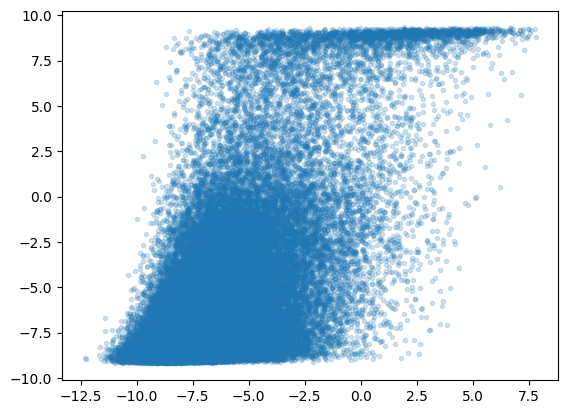

In [63]:
pyplot.plot(pred_scores, torch.logit(torch.tensor(scores) - 1e-6).detach().cpu().numpy(), '.', alpha=0.2)

In [56]:
from sklearn.metrics import average_precision_score, roc_auc_score

In [65]:
roc_auc_score(scores > 0.5, pred_scores)

0.9252067312180519

In [66]:
average_precision_score(scores > 0.5, pred_scores)

0.5489345648204119

In [57]:
OUTPUT_PATH = './weight/014/nsfw-detector_vision.pt'

torch.save(model.state_dict(), OUTPUT_PATH)